# CAB420, DCNNs, Example 5 - Residual Networks (ResNets)
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Neural networks can be put together in lots of different ways. The topology of the network controls how information flows through the networks - and how gradients flow backwards. This example will look at ResNet style networks, which use residual blocks and allows for deeper, yet smaller (in terms of number of parameters), networks.

## Too Long; Didn't Read:
* ResNets use skip connections to allow for deeper networks. This involves the use of addition layers to add outputs from multiple stages of the network together; but it also provides a more direct path from the output back to the input.
* There are two types of skip connections, one that directly add the layers, and ones that first need to sample one signal so it can be added to the second. We see the second when the skip connection spans a downsampling block.
* The need for skip connections means that more care must be taken when building the network, and we need to move beyond simple feed-forward designs.

In [1]:
import os
import datetime
import numpy

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras import activations
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Data Setup
We're using Fastion-MNIST again. You'll get sick of it soon.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();    

## The Network

Residual Networks use skip connections. These help shift data through the network, which allows deeper networks and faster training. It does make the network setup a bit more confusing though. 

There are a couple of different ways that we can think of ResNets, one way is to build a backbone, and then add skip connections. The other way, which is the way we'll use here, is to think of it as a series of smaller units, each of which contains multiple paths, and stack those together.

### Helper Functions

To build these, we're going to use some functions. These are largely taken from the Keras example [here](https://keras.io/examples/cifar10_resnet/). They are adapted slightly to not actually specify an output, and allow a bit more configuration of the number of stages and size of the stages, but other than that are fairly faithful to the Keras example.

In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """
    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y


def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

#### ResNet v1

With our helper functions out the way, let's build a network.

We're using Fashion MNIST, so our input is the same as usual, and our output will be a 10 unit dense layer. We'll build a network with two stages and one residual block in each stage.

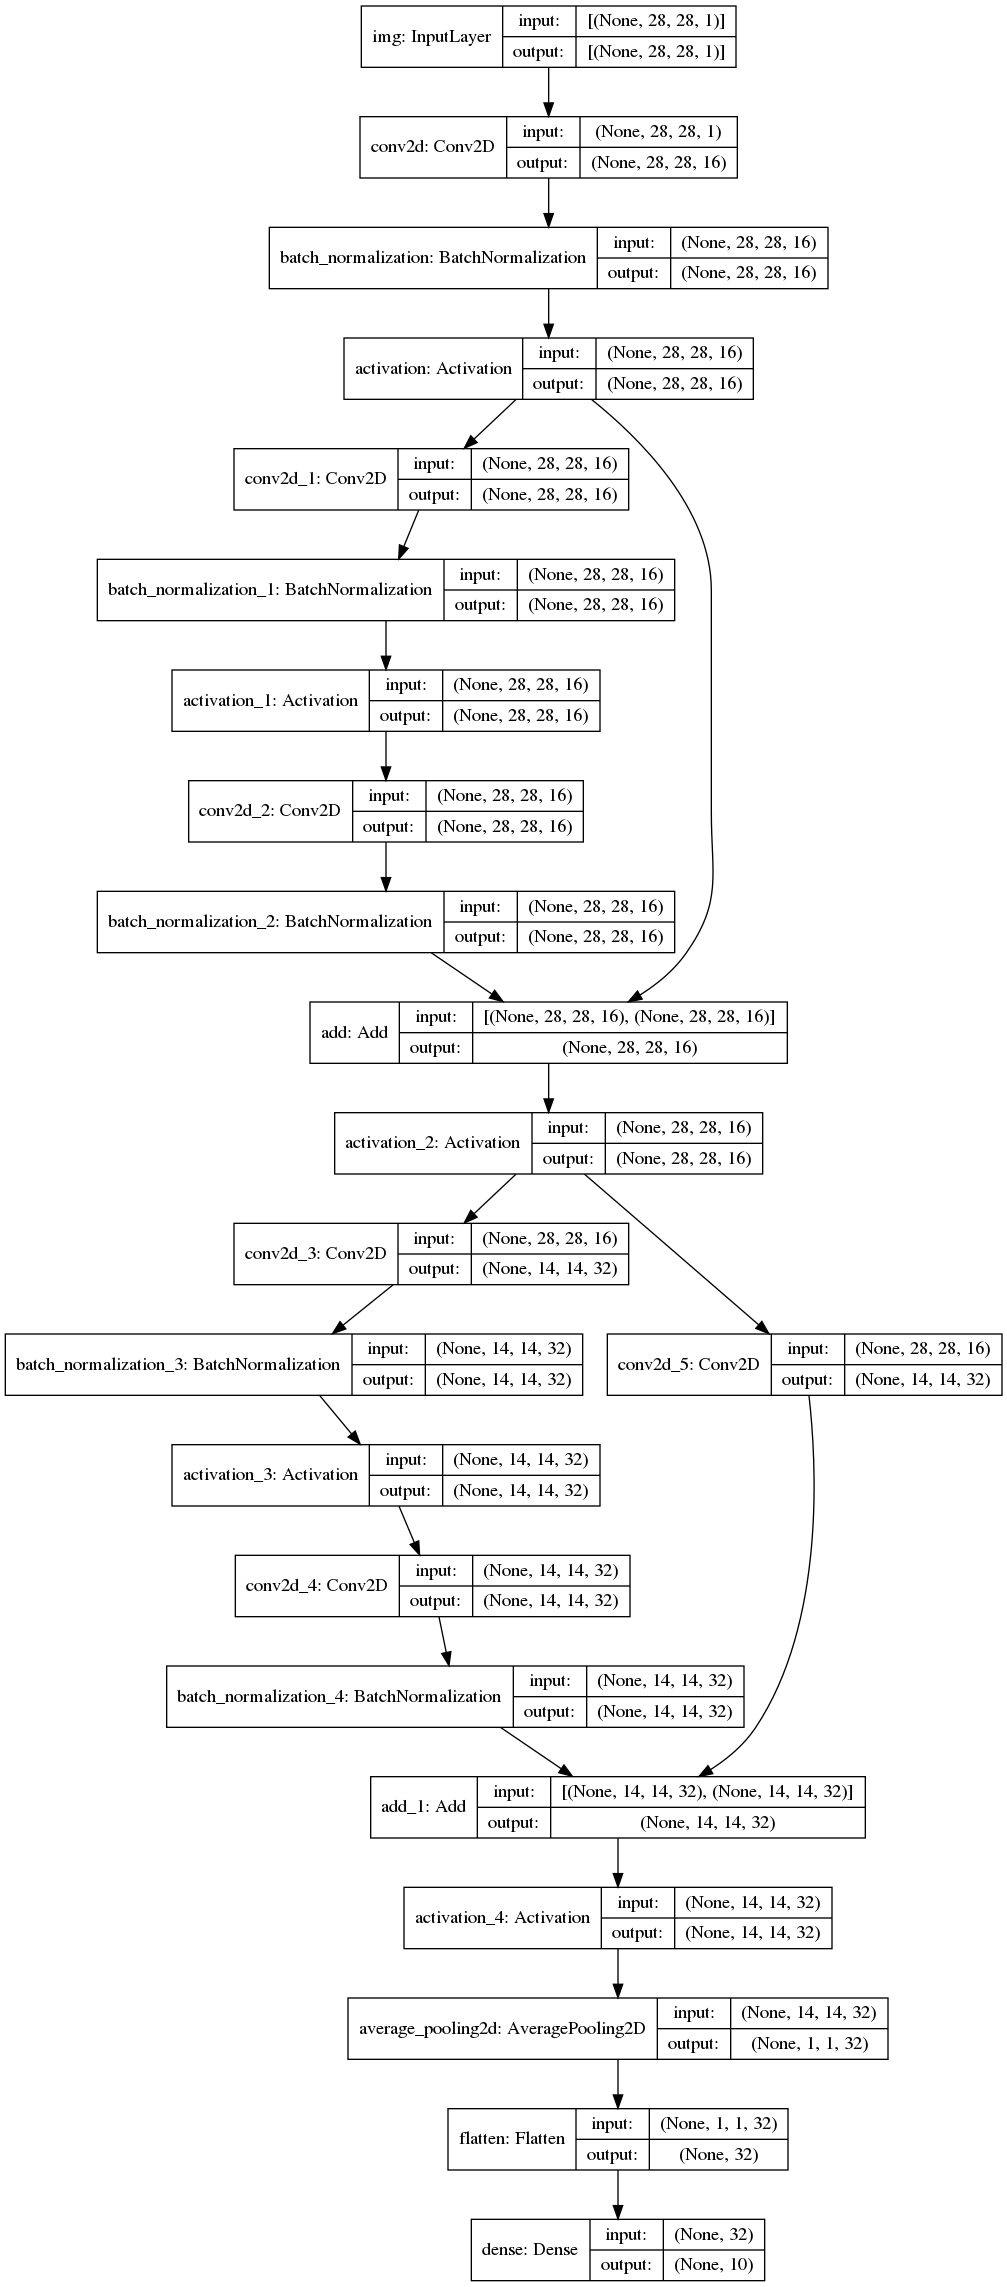

In [4]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [16, 32], 1, 14)
output = Dense(10)(x)
model_resnet_v1 = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
keras.utils.plot_model(model_resnet_v1, show_shapes=True)

Our network can be seen as having four bits:
* We have the input block, which also contains a single 2D convolution layer.
* We have the first residual block, which contains 16 filters in it. There are two paths through this block. Either we can go via a couple of 2D convolution layers, or we can just skip those and jump straight to the addition where the input representation is combined with the representation learned by those convolution layers.
* We have a second residual block, which looks very much like the first, just with 32 filters.
* We have our output, which simply has an average pooling layer, and then our output

On the whole, this results in a fairly deep, yet lightweight (in terms of number of parameters) network.

In [5]:
model_resnet_v1.summary()

Model: "simple_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
___________________________________________________________________________________

#### ResNet v2

Let's have a look at a v2 network now.

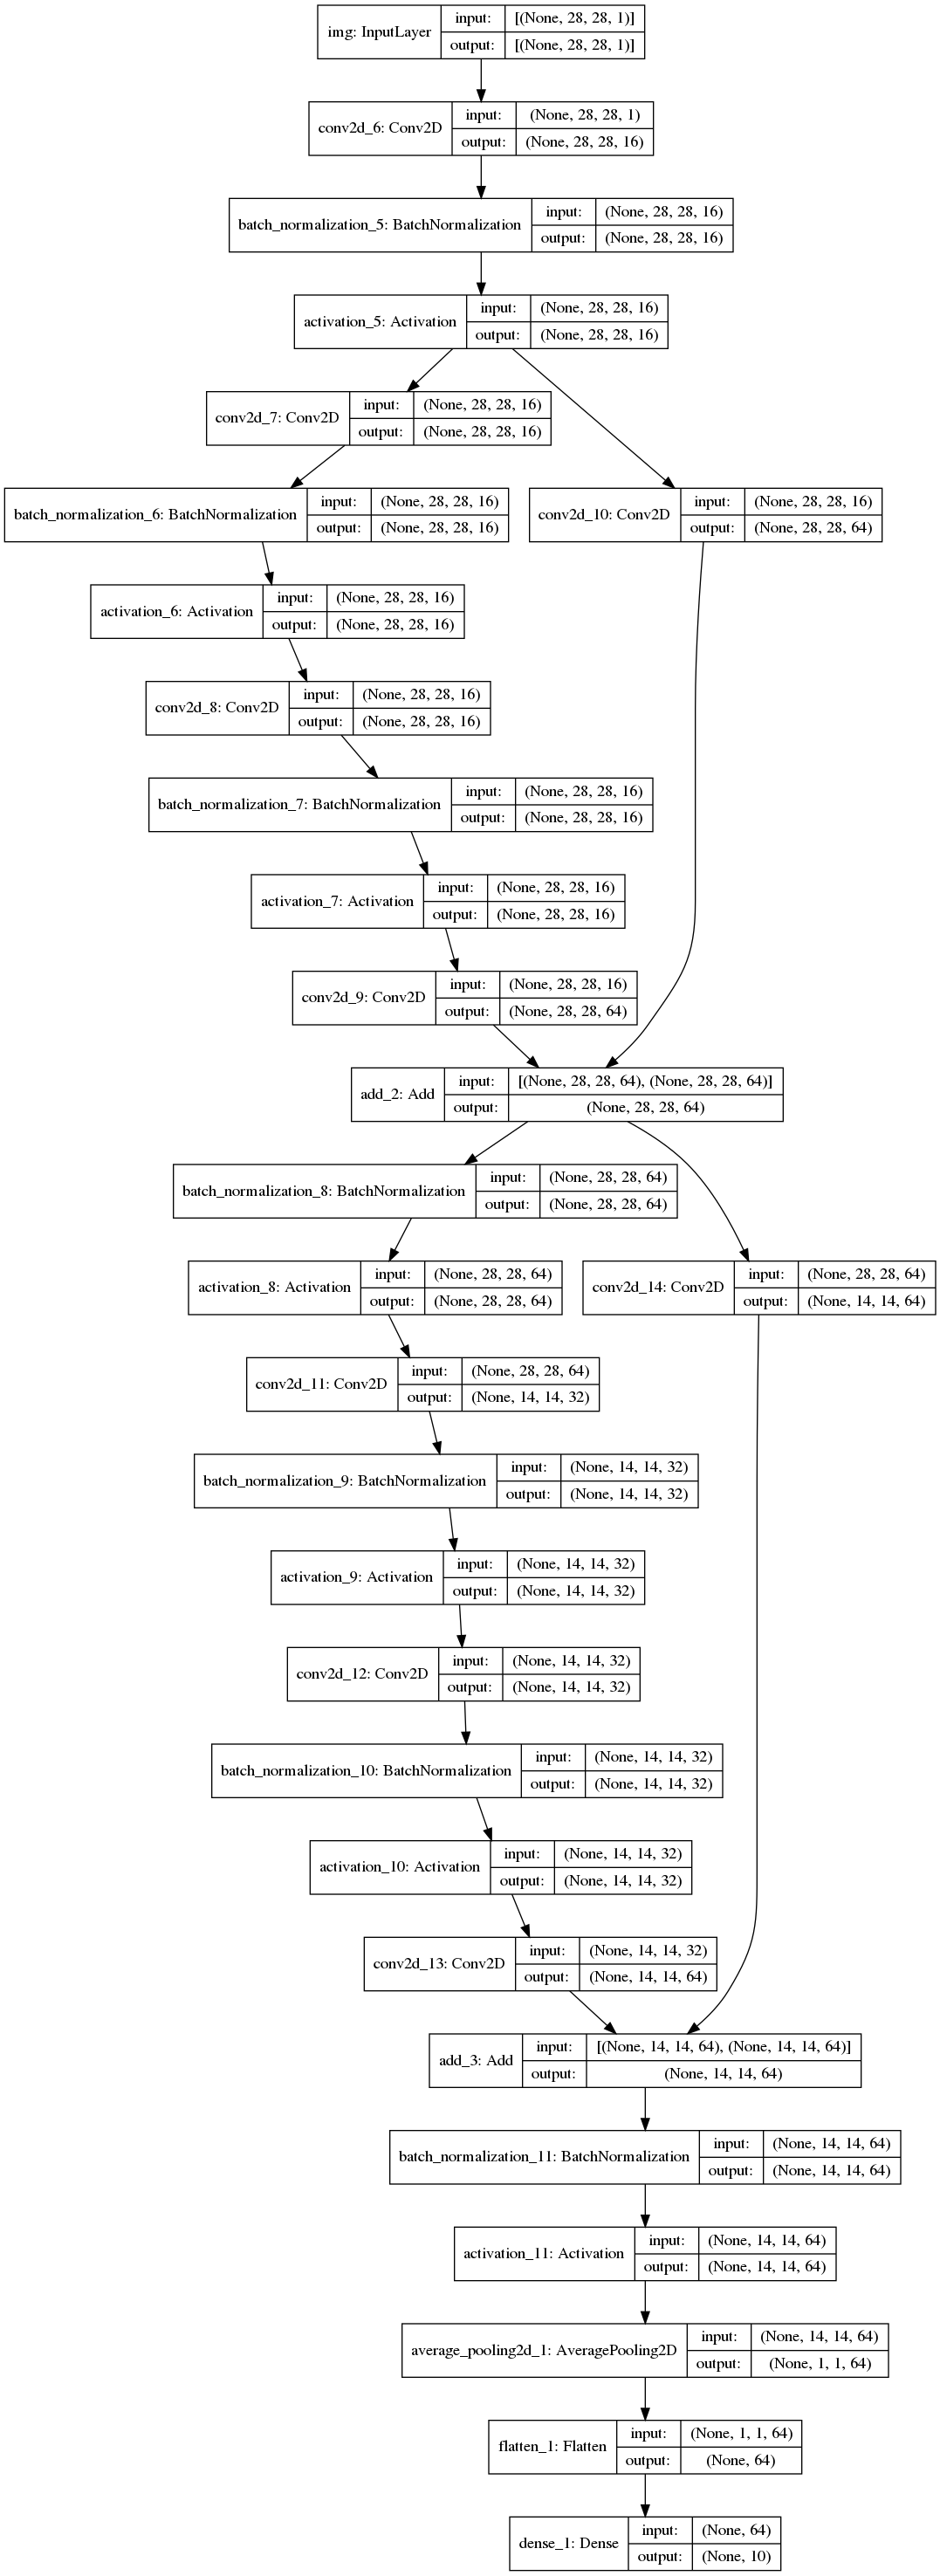

In [6]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [16, 32], 1, 14)
output = Dense(10)(x)
model_resnet_v2 = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v2')
keras.utils.plot_model(model_resnet_v2, show_shapes=True)

The end result is a much deeper network. Looking at the network, we can see we have more convolution filters in some places than we did before. This version makes use of more 1x1 convolutions to adjust the representation size and include some extra convolution operations, without greatly increasing the number of parameters, giving us a deeper network overall.

In [7]:
model_resnet_v2.summary()

Model: "simple_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 28, 28, 16)   64          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 28, 28, 16)   0           batch_normalization_5[0][0]      
___________________________________________________________________________________

### Training Our Networks

Let's train these things now. We'll stick to our fairly standard approach. Note that I have `from_logits=True` here as there is no `softmax` loss on our dense layer.

In [8]:
model_resnet_v1.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_resnet_v1.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 5s 5ms/step - loss: 1.3975 - accuracy: 0.5573 - val_loss: 0.8707 - val_accuracy: 0.6787
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6103 - accuracy: 0.7954 - val_loss: 0.7440 - val_accuracy: 0.7514
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.5012 - accuracy: 0.8351 - val_loss: 0.5105 - val_accuracy: 0.8354
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4520 - accuracy: 0.8524 - val_loss: 0.5767 - val_accuracy: 0.8074
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4175 - accuracy: 0.8620 - val_loss: 0.4697 - val_accuracy: 0.8439
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3962 - accuracy: 0.8714 - val_loss: 0.6223 - val_accuracy: 0.8027
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3756 - accuracy: 0.8783 - val_loss: 0.4432 - val_accuracy: 0.8513
Epoch 

313/313 - 0s - loss: 0.5181 - accuracy: 0.8404
Test loss: 0.5181334018707275
Test accuracy: 0.840399980545044


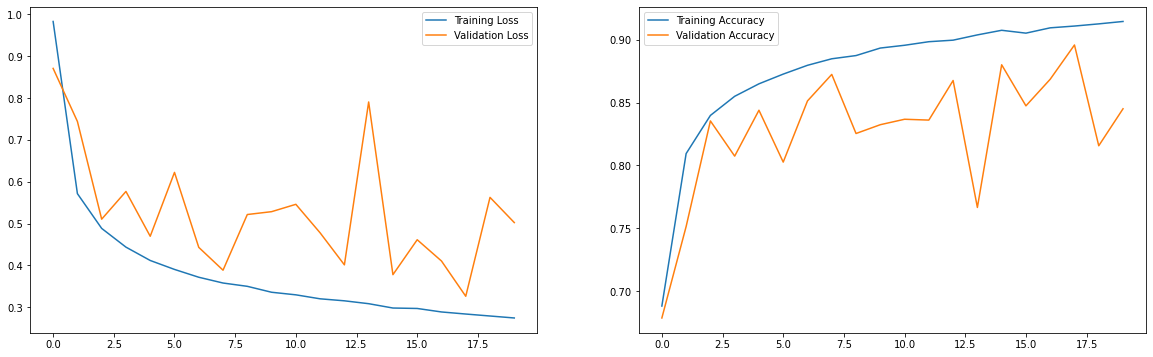

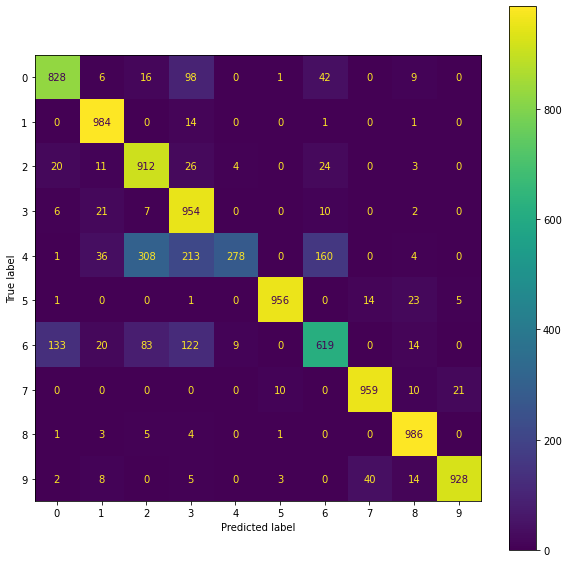

In [9]:
plot_training(history)
eval_model(model_resnet_v1, x_test, y_test)

In [10]:
model_resnet_v2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_resnet_v2.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 10s 13ms/step - loss: 1.3979 - accuracy: 0.5843 - val_loss: 0.7537 - val_accuracy: 0.7579
Epoch 2/20
750/750 [==============================] - 9s 12ms/step - loss: 0.5964 - accuracy: 0.8191 - val_loss: 0.5013 - val_accuracy: 0.8447
Epoch 3/20
750/750 [==============================] - 9s 12ms/step - loss: 0.4835 - accuracy: 0.8530 - val_loss: 0.5602 - val_accuracy: 0.8231
Epoch 4/20
750/750 [==============================] - 9s 12ms/step - loss: 0.4333 - accuracy: 0.8703 - val_loss: 0.4949 - val_accuracy: 0.8394
Epoch 5/20
750/750 [==============================] - 9s 12ms/step - loss: 0.4013 - accuracy: 0.8784 - val_loss: 0.6793 - val_accuracy: 0.7577
Epoch 6/20
750/750 [==============================] - 9s 12ms/step - loss: 0.3736 - accuracy: 0.8899 - val_loss: 0.3923 - val_accuracy: 0.8842
Epoch 7/20
750/750 [==============================] - 9s 12ms/step - loss: 0.3581 - accuracy: 0.8937 - val_loss: 0.4312 - val_accuracy: 0.865

313/313 - 1s - loss: 0.4123 - accuracy: 0.8731
Test loss: 0.4122501611709595
Test accuracy: 0.8730999827384949


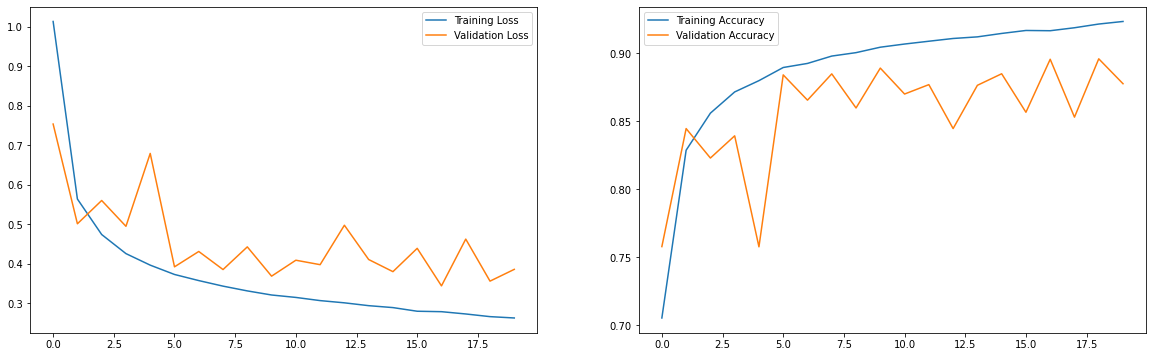

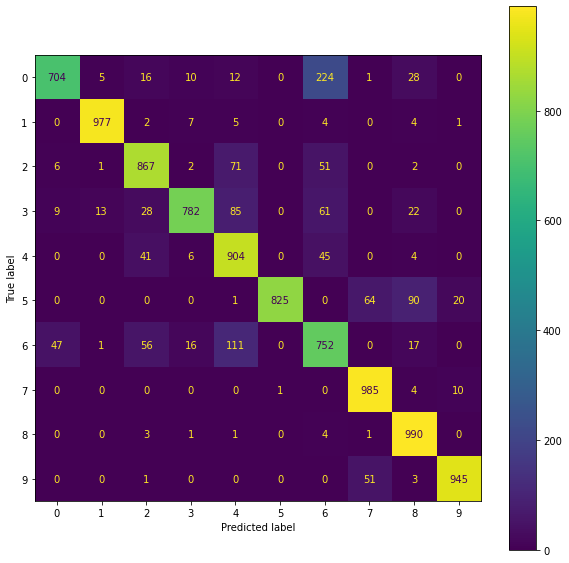

In [11]:
plot_training(history)
eval_model(model_resnet_v2, x_test, y_test)

Both networks work pretty well here.

One thing worth noting is that while we have fewer parameters, the networks aren't faster. As we've noted elsewhere, not all parameters are equal. Convolution layers may have fewer parameters than a dense layer, but they are (usually) slower to compute due to the need to "slide" the kernel across the image.

## Making things Bigger

Because we can. Let's add another residual block, and make the blocks themselves bigger.

#### v1

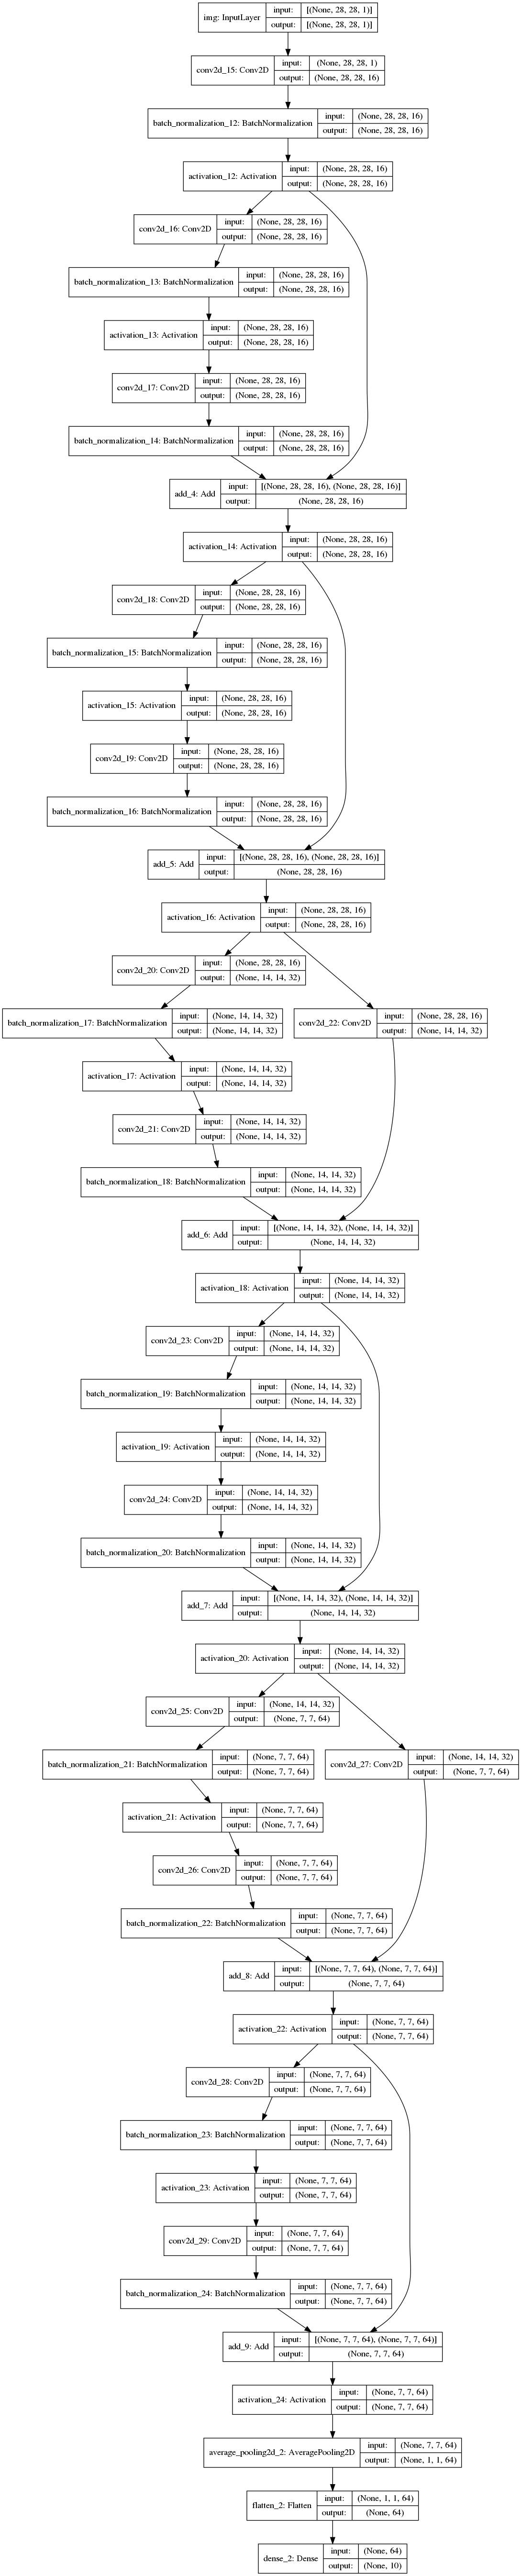

In [12]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 7)
output = Dense(10)(x)
model_resnet_v1_b = keras.Model(inputs=inputs, outputs=output, name='resnet_v1')
keras.utils.plot_model(model_resnet_v1_b, show_shapes=True)

In [13]:
model_resnet_v1_b.summary()

Model: "resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 28, 28, 16)   64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 28, 28, 16)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________

In [14]:
model_resnet_v1_b.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_resnet_v1_b.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 9s 10ms/step - loss: 0.8260 - accuracy: 0.7468 - val_loss: 0.6043 - val_accuracy: 0.8180
Epoch 2/20
750/750 [==============================] - 8s 10ms/step - loss: 0.4410 - accuracy: 0.8778 - val_loss: 0.5013 - val_accuracy: 0.8622
Epoch 3/20
750/750 [==============================] - 7s 10ms/step - loss: 0.3761 - accuracy: 0.9020 - val_loss: 0.6146 - val_accuracy: 0.8327
Epoch 4/20
750/750 [==============================] - 7s 10ms/step - loss: 0.3375 - accuracy: 0.9150 - val_loss: 0.6843 - val_accuracy: 0.7930
Epoch 5/20
750/750 [==============================] - 7s 10ms/step - loss: 0.3042 - accuracy: 0.9249 - val_loss: 0.4253 - val_accuracy: 0.8882
Epoch 6/20
750/750 [==============================] - 7s 10ms/step - loss: 0.2797 - accuracy: 0.9332 - val_loss: 0.5525 - val_accuracy: 0.8558
Epoch 7/20
750/750 [==============================] - 7s 10ms/step - loss: 0.2688 - accuracy: 0.9369 - val_loss: 0.4411 - val_accuracy: 0.8829

313/313 - 1s - loss: 0.5882 - accuracy: 0.8787
Test loss: 0.5881730318069458
Test accuracy: 0.8787000179290771


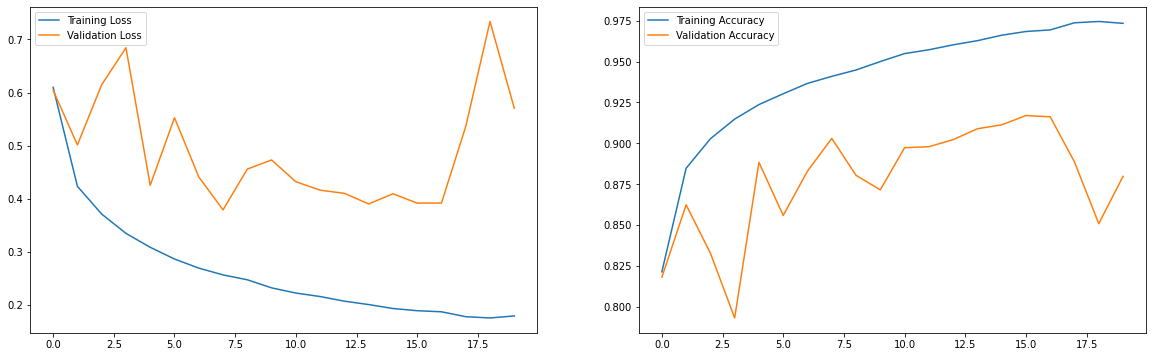

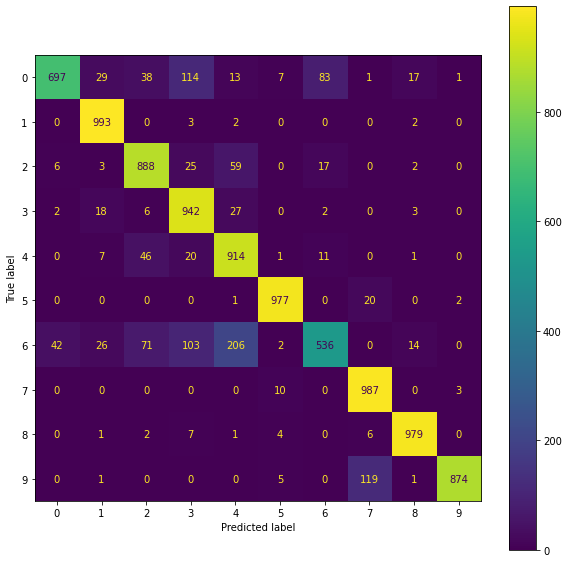

In [15]:
plot_training(history)
eval_model(model_resnet_v1_b, x_test, y_test)

Performance has gone up a few percent. Again though, this is a good illustration of the diminishing returns that we see.

#### v2

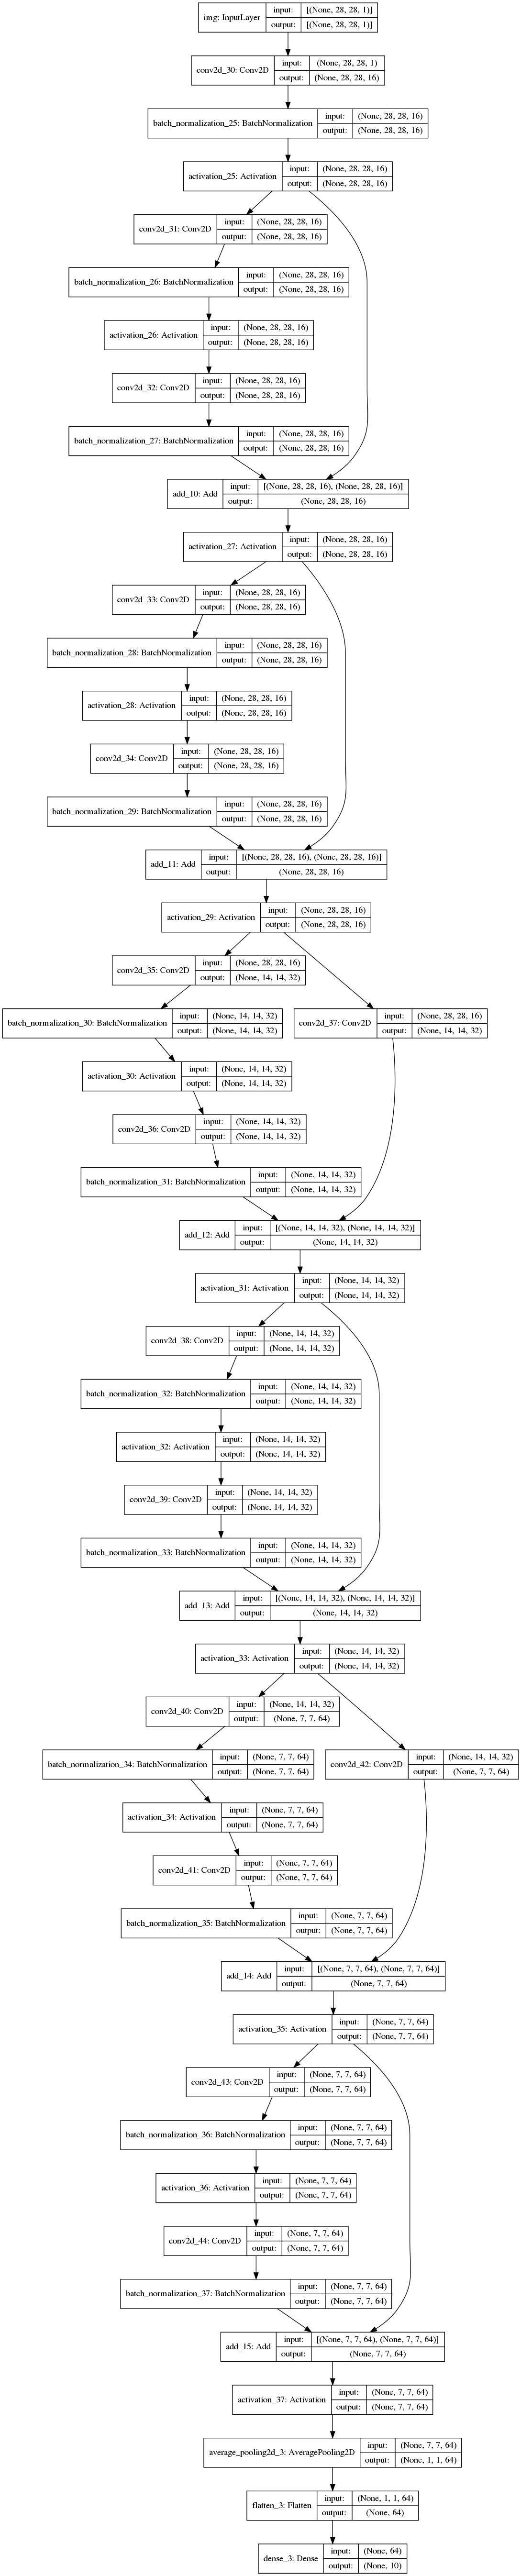

In [16]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 7)
output = Dense(10)(x)
model_resnet_v2_b = keras.Model(inputs=inputs, outputs=output, name='resnet_v1')
keras.utils.plot_model(model_resnet_v2_b, show_shapes=True)

In [17]:
model_resnet_v2_b.summary()

Model: "resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 28, 28, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 28, 28, 16)   64          conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 28, 28, 16)   0           batch_normalization_25[0][0]     
__________________________________________________________________________________________

In [18]:
model_resnet_v2_b.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_resnet_v2_b.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 9s 10ms/step - loss: 0.9005 - accuracy: 0.7348 - val_loss: 0.8265 - val_accuracy: 0.7526
Epoch 2/20
750/750 [==============================] - 7s 10ms/step - loss: 0.4278 - accuracy: 0.8830 - val_loss: 0.5953 - val_accuracy: 0.8329
Epoch 3/20
750/750 [==============================] - 7s 10ms/step - loss: 0.3588 - accuracy: 0.9067 - val_loss: 0.3972 - val_accuracy: 0.8980
Epoch 4/20
750/750 [==============================] - 7s 10ms/step - loss: 0.3175 - accuracy: 0.9217 - val_loss: 0.3865 - val_accuracy: 0.8982
Epoch 5/20
750/750 [==============================] - 8s 10ms/step - loss: 0.2941 - accuracy: 0.9296 - val_loss: 0.4222 - val_accuracy: 0.8808
Epoch 6/20
750/750 [==============================] - 8s 10ms/step - loss: 0.2748 - accuracy: 0.9348 - val_loss: 0.5225 - val_accuracy: 0.8578
Epoch 7/20
750/750 [==============================] - 8s 10ms/step - loss: 0.2513 - accuracy: 0.9444 - val_loss: 0.5180 - val_accuracy: 0.8632

313/313 - 1s - loss: 0.5144 - accuracy: 0.8992
Test loss: 0.5144219994544983
Test accuracy: 0.8992000222206116


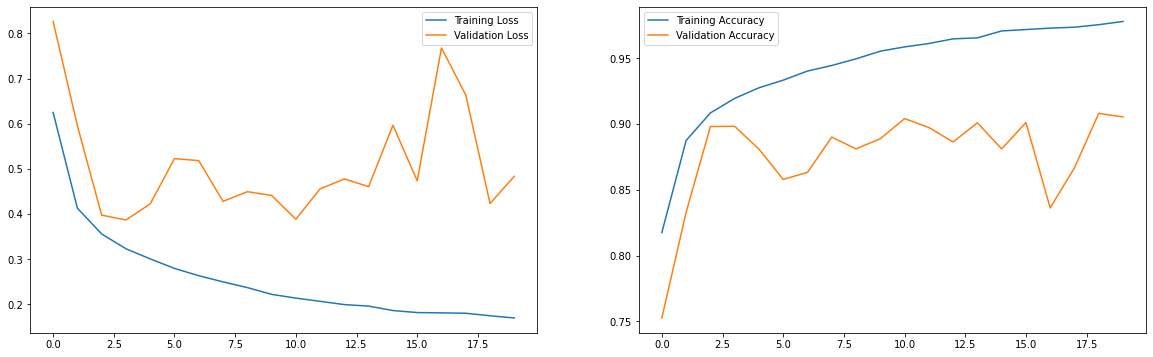

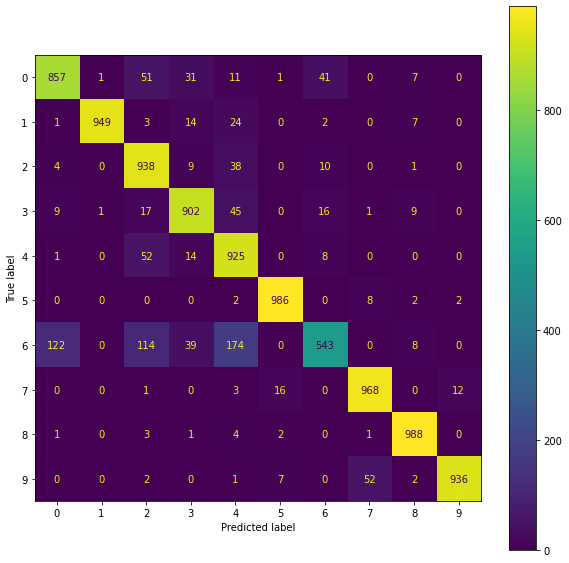

In [19]:
plot_training(history)
eval_model(model_resnet_v2_b, x_test, y_test)

We have a slight gain here too, again though, it's not huge.

## Final Thoughts

So are ResNets the saviour of humankind? 

Spoiler alert: probably not.

But, we can use these to get deeper networks that we can actually train. This does make a difference for large scale problems (like ImageNet) where we have very large datasets with lots of classes and complex decision boundaries to learn. For Fashion MNIST, we simply don't have a complex enough problem to really see the benefits. That said, we could afford to train our networks for a little longer, and probably get a bit more performance out of them.

Skip connections also have applications well beyond what we've seen here, and are a common tool in most advanced deep networks. Their ability to provide alternative pathways from the loss to the input, and usually a shorter pathway, makes them very handy for a lot of problems.